The discriminative **Support Vector Machine (SVM)** classifier is a supervised machine learning model that learns an optimal separating $n$-dimensional hyperplane to distinguish different observations of training data according to their corresponding class labels. Until recently (before to the advent of deep learning approaches) SVMs have been used in a variety of applications such as isolated handwritten digit recognition, object recognition, speaker identification, face detection in images, and text categorisation.

# 0. LIBRARIES IMPORT

In [2]:
# import the numpy, scipy and pandas data science library
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm

# import sklearn data and data pre-processing libraries
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# import torchvision library
import torchvision

# import sklearn HOG feature library
from skimage.feature import hog

# import sklearn support vector classifier (svc) library
from sklearn.svm import SVC

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
plt.style.use('seaborn')
random_seed = 42
import warnings
warnings.filterwarnings('ignore')

<ipython-input-3-abdf8a0efa7c>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 1. DATA PROCESSING

## a. data acquisition

The **Iris Dataset** is a classic and straightforward dataset often used as a "Hello World" example in multi-class classification. This data set consists of measurements taken from three different types of iris flowers (referred to as **Classes**),  namely the Iris Setosa, the Iris Versicolour, and, the Iris Virginica) and their respective measured petal and sepal length (referred to as **Features**).

In total, the dataset consists of **150 samples** (50 samples taken per class) as well as their corresponding **4 different measurements** taken for each sample. Please, find below the list of the individual measurements:

>- `Sepal length (cm)`
>- `Sepal width (cm)`
>- `Petal length (cm)`
>- `Petal width (cm)`

Let's load the dataset and conduct a preliminary data assessment:

In [4]:
iris = datasets.load_iris()

Print and inspect the names of the four features contained in the dataset:

In [5]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Determine and print the feature dimensionality of the dataset:

In [6]:
iris.data.shape

(150, 4)

Print and inspect the names of the three classes contained in the dataset:

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's conduct a more in-depth data assessment. Therefore, we plot the feature distributions of the Iris dataset according to their respective class memberships as well as the features pairwise relationships.

<Figure size 1000x1000 with 0 Axes>

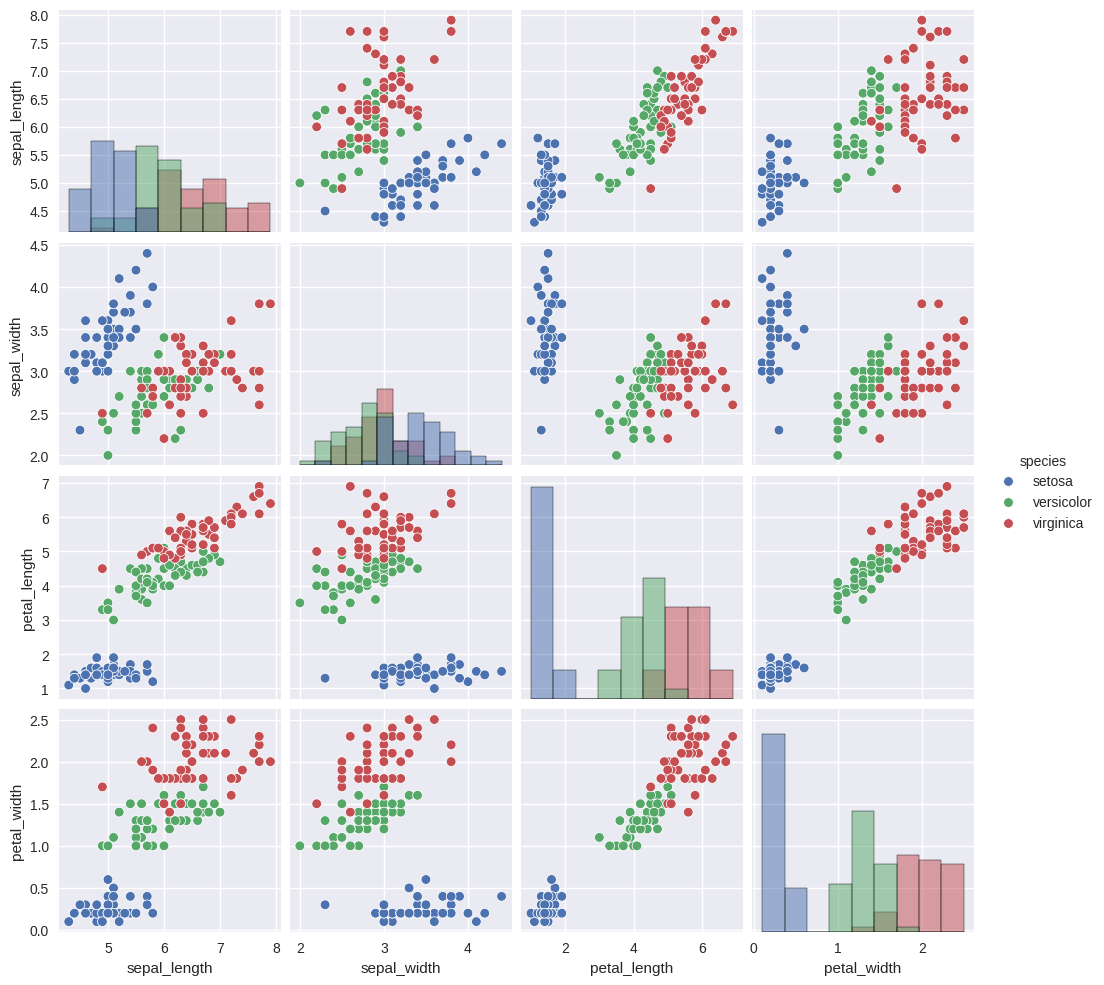

In [8]:
# init the plot
plt.figure(figsize=(10, 10))

# load the dataset also available in seaborn
iris_plot = sns.load_dataset("iris")

# plot a pairplot of the distinct feature distributions
sns.pairplot(iris_plot, diag_kind='hist', hue='species');

It can be observed from the created Pairplot, that most of the feature measurements that correspond to flower class "setosa" exhibit a nice **linear separability** from the feature measurements of the remaining flower classes. Besides, the flower classes "versicolor" and "virginica" exhibit a commingled and **non-linear separability** across all the measured feature distributions of the Iris Dataset.

## b. train/evaluation sets split

To understand and evaluate the performance of any trained **supervised machine learning** model, it is good practice, to divide the dataset into a **training set** (the fraction of data records solely used for training purposes) and an **evaluation set** (the fraction of data records solely used for evaluation purposes). Pls. note, the **evaluation set** will never be shown to the model as part of the training process.

We set the fraction of evaluation records to **30%** of the original dataset:

In [9]:
eval_fraction = 0.3

In [10]:
# 70% training and 30% evaluation
x_train, x_eval, y_train, y_eval = train_test_split(iris.data, iris.target, test_size=eval_fraction, random_state=random_seed, stratify=None)

# 2. MODELING

## a. understanding SVM

Let's suppose we are given $l$ observations. Each observation consists of a pair: a vector $x_{i} \in \mathbb{R}^{n}, i=1, ..., l$ and the associated "truth" $y_{i}$, provided by a trusted source. In the context of a face detection task, $x_{i}$ might be vector of pixel values (e.g. $n$=256 for 1024x1024 pixel image), and $y_{i}$ would be $1$ if the image contains a face, and $-1$ otherwise.

### i. Linear SVM Classifiers - The Linear Separable Case

Suppose we have some hyperplane which separates the positive from the negative examples referred to as "separating hyperplane". The points $x$ which lie on the hyperplane satisfy the following equation $w \cdot x + b = 0$, where $w$ is normal to the hyperplane, $|b|/||w||$ is the perpendicular distance from the hyperplane to the origin, and $||w||$ is the Euclidean norm of $w$. Let $d_{+}$ ($d_{-}$) be the shortest distance from the separating hyperplane to the closest positive (negative) example. We define the "margin" of a separating hyperplane to be $d_{+} + d_{-}$. In the context of the linearly separable case, the support vector algorithm simply looks for the separating hyperplane with the maximum margin.

Suppose that all the training data satisfies the following constraints:

$$ x_{i} \cdot w + b \geq + 1, y_{i} = +1 $$

$$ x_{i} \cdot w + b \leq - 1, y_{i} = -1 $$

This can be combined into one set of inequalities:

$$y_{i}(x_{i} \cdot w + b) - 1 \geq 0, \forall_{i}$$

Let's now consider the points for which the equality $x_{i} \cdot w + b \geq + 1$ holds. These points lie on a hyperplane $H_{1}: x_{i} \cdot w + b = + 1$ with normal $w$ and perpendicular distance from the origin $|1-b|/||w||$. Similarly, the points for which the equality $x_{i} \cdot w + b \leq - 1$ holds lie on the hyperplane $H_{2}: x_{i} \cdot w + b = -1$, with normal again $w$, and perpendicular distance from the origin $|-1-b|/||w||$. Hence $d_{+} = d_{-} = 1 / ||w||$ and the margin is simply 2/||w||. Note that $H_{1}$ and $H_{2}$ are parallel and that no training points $x_{i}$ fall between them. Thus we can find a pair of hyperplanes which correspond to a maximum margin by minimizing $||w||^{2}$, subject to constraint $y_{i}(x_{i} \cdot w + b) - 1 \geq 0$. Those training points $x_{i}$ which wind up lying on one of the hyperplanes $H_{1}$, $H_{2}$, and whose removal would change the solution found, are referred to as **"support vectors"**.

### ii. a "Primal"  Optimization Objective Formulation

We can reformulate the objective of finding such a max-margin seperating hyperplane as a Lagrangian optimization objective. Thereby, we introduce a set of positive Lagrange multipliers $\alpha_{i}, i=1, ..., l$ which turns the search for a max-margin seperating hyperplane into solving the following Lagrangian:

$$L_{P} = \frac{1}{2}||w||^{2} - \sum_{i=1}^{l} \alpha_{i}y_{i}(x_{i} \cdot w + b) + \sum_{i=1}^{l}\alpha_{i}$$

We must now minimize $L_{P}$, referred to as the **"primal"**, with respect to $w$, $b$. Thereby,

> 1. the minimization of the first term $\frac{1}{2}||w||^{2}$ maximizes the margin of the separating hyperplane,
> 2. the maximization of the second term $\sum_{i=1}^{l} \alpha_{i}y_{i}(x_{i} \cdot w + b)$ maximizes the number of correctly classfied training samples,
> 3. the minimization of the third term $\sum_{i=1}^{l}\alpha_{i}$ minimizes the number of support vectors.

Minimization of $L_{P}$ is a convex quadratic programming problem, since the objective function is itself convex, and those points for which $\alpha_{i} > 0$ that satisfy the constraints also form a convex set. Again, those points are called "support vectors", and lie on one of the hyperplanes $H_{1}$, $H_{2}$.

### iii. a "Dual" Optimization Objective Formulation

Requiring that the gradient of $L_{P}$ with respect to $w$ and $b$ vanish result in the conditions, that $w = \sum_{i=1}^{l} \alpha_{i}y_{i}x_{i}$ and $\sum_{i=1}^{l}\alpha_{i}y_{i} = 0$. Using those conditions, the above shown Lagrangian can be reformulated to derive its **"dual"** formulation:

$$L_{D} = \sum_{i=1}^{l}\alpha_{i} + \frac{1}{2} \sum_{i,j=1}^{l} \alpha_{i}\alpha_{j}y_{i}y_{j}<x_{i}, x_{j}>$$

Note that solving the dual formulation doesn't depend on $w$ anymore. It only depends on the samples $x_{i} \in \mathbb{R}^{n}, i=1, ..., l$ of the training dataset as well as the associated labels $y_{i}$. This indicates that the optimal seperating hyperplane $H^{*}$ becomes a linear function of the data. Note also that if we formulate the problem, as above, with $b=0$, requires that all hyperplanes contain the origin. However, this is a mild restriction for high dimensional spaces since it amounts to reducing the number of degrees of freedom by one.

## b. training SVM

The `Scikit-Learn` (https://scikit-learn.org) machine learning library provides a variety of machine learning algorithms that can be easily interfaced using the Python programming language. Among others the library also contains a variety of supervised classification algorithms such as the **Support Vector Machine (SVM)** classifier. The SVM classifier can be trained "off-the-shelf" to solve the dual Lagrangian $L_{D}$ optimization objective formulated above. Let's instantiate one of the SVM classifiers available in `Scikit-Learn` to learn a linear seperating hyperplane:

In [11]:
# init the Support Vector Machine classifier
svm = SVC(kernel='linear', random_state=random_seed)

Train or fit the SVM classifier using the training dataset features and labels:

In [12]:
# train / fit the Support Vector Machine classifier
svm.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

### i. evaluation

After fitting the training data, the optimal seperating hyperplane $H^{*}$ learned by the SVM model can then be used to predict the corresponding class labels $y_{i}'$ of so far unknown observations $x_{i}'$. We will utilize the trained model to predict the class labels of the remaining observations contained in the evaluation dataset:

In [13]:
y_pred = svm.predict(x_eval)

In [14]:
print('Model classification accuracy: {}%'.format(str(metrics.accuracy_score(y_eval, y_pred) * 100)))

Model classification accuracy: 100.0%


Determine the number of **misclassified** data sampels in the evaluation dataset:

In [15]:
print('Number of mislabeled points out of a total {} points: {}'.format(x_eval.shape[0], np.sum(y_eval != y_pred)))

Number of mislabeled points out of a total 45 points: 0


Determine and plot the **confusion matrix** of the individual predictions:

In [16]:
# determine the prediction confusion matrix
mat = confusion_matrix(y_eval, y_pred)

Plot the **confusion matrix** of the individual predictions:

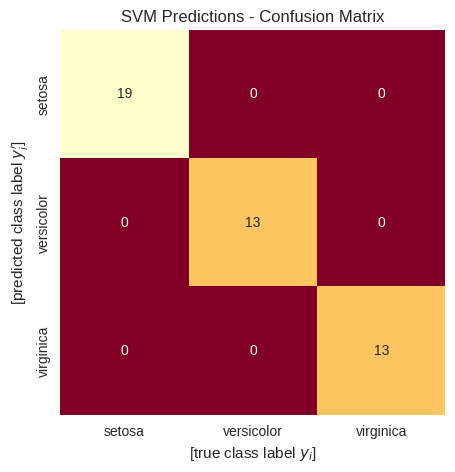

In [17]:
# init the plot
plt.figure(figsize=(5, 5))

# plot confusion matrix heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=iris.target_names, yticklabels=iris.target_names)

# add plot axis labels
plt.xlabel('[true class label $y_{i}$]')
plt.ylabel('[predicted class label $y_{i}\'$]')

# add plot title
plt.title('SVM Predictions - Confusion Matrix');

### ii. prediction of classes of unknown Iris Flower observations

**First unknown iris flower:** Now that we have trained and evaluated our SVM classifier let's apply it to two so far unknown or unseen **iris flower** observations. The first **iris flower** observation $x^{s1}$ exhibits the following observed feature values: $x^{s1} = \{x_{sl}=5.8, x_{sw}=3.5, x_{pl}=1.5, x_{pw}=0.25\}$:

Let's convert those measurements into a feature vector $x^{s1}$:

In [18]:
# init features of the first unknown iris flower observation
sepal_length = 5.8
sepal_width  = 3.5
petal_length = 1.5
petal_width  = 0.25

# create the observation feature vector
x_s1_feature_vector = [sepal_length, sepal_width, petal_length, petal_width]

# print the feature vector
print(x_s1_feature_vector)

[5.8, 3.5, 1.5, 0.25]


Let's now use our trained SVM model $h$ to predict the class $c^{*}$ of the unknown iris flower $x^{s1}$:

In [19]:
# determine class label prediction of the first unknown observation
class_prediction_sample_1 = svm.predict([x_s1_feature_vector])

# convert predicted class label to class name
print(iris.target_names[class_prediction_sample_1[0]])

setosa


Let's build an intuition of the distinct iris flower class distributions including the current iris flower observation:

<Figure size 1000x1000 with 0 Axes>

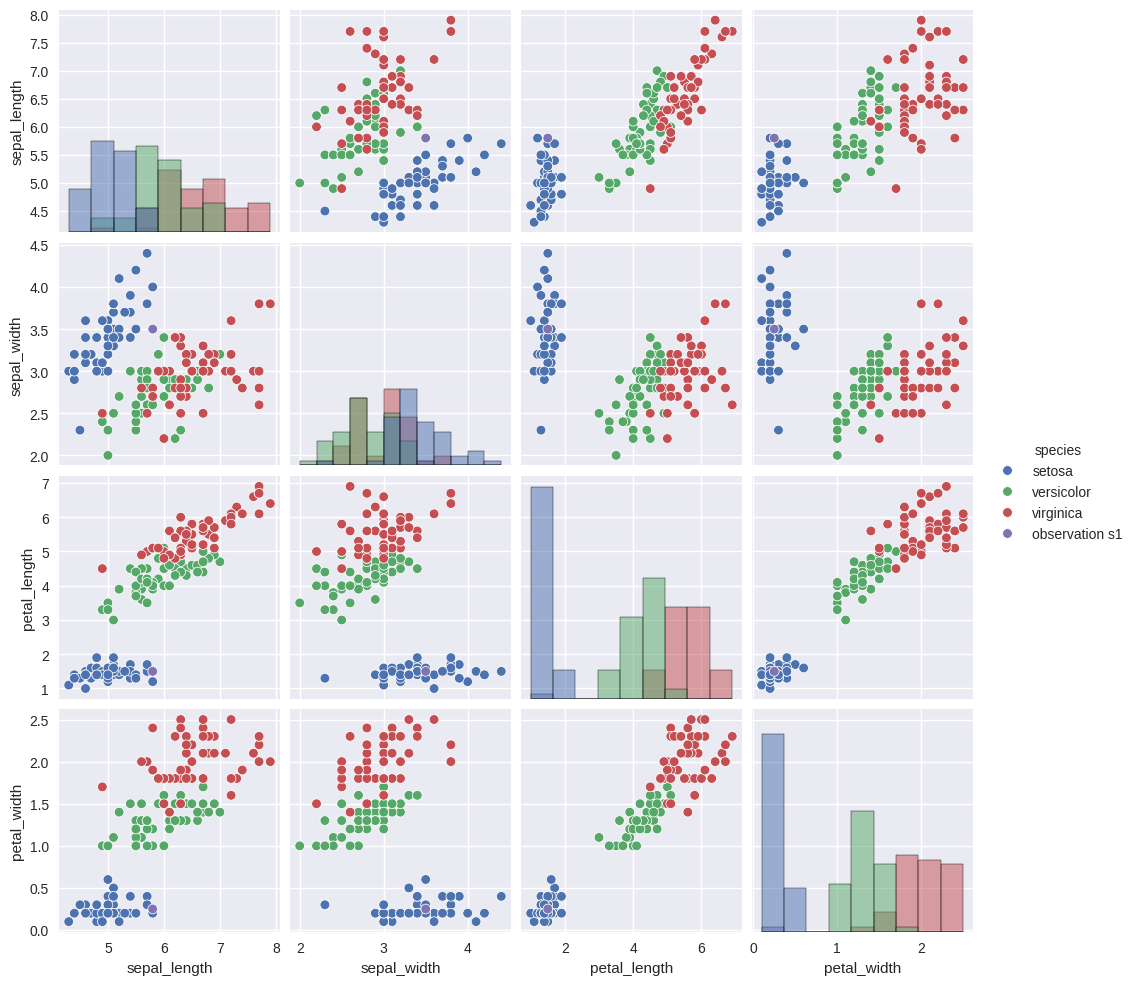

In [20]:
# init the plot
plt.figure(figsize=(10, 10))

# load the dataset also available in seaborn
iris_plot = sns.load_dataset('iris')

# define the new observation feature vector
x_s1_feature_vector = [5.8, 3.5, 1.5, 0.25, 'observation s1']

# add observation to the iris dataset
new_observation_df = pd.DataFrame([x_s1_feature_vector], columns=iris_plot.columns)
iris_plot = pd.concat([iris_plot, new_observation_df], ignore_index=True)

# plot a pairplot of the distinct feature distributions
sns.pairplot(iris_plot, diag_kind='hist', hue='species');

Ok, the feature distributions of the feature values observable for the unknown iris flower $x^{s1}$ exhibit a high likelihood of beeing of class **setosa**.

**Second unknown iris flower:** Let's apply the learned SVM model to a second unknown or unseen **iris flower** observations. The second **iris flower** observation $x^{s2}$ exhibits the following observed feature values $x^{s2} = \{x_{1}=7.8, x_{2}=2.3, x_{3}=6.4, x_{4}=2.5\}$:

Let's again convert those measurements into a feature vector $x^{s2}$:

In [21]:
# init features of the second unknown iris flower observation
sepal_length = 7.8
sepal_width  = 2.3
petal_length = 6.4
petal_width  = 2.5

# create the observation feature vector
x_s2_feature_vector = [sepal_length, sepal_width, petal_length, petal_width]

# print the feature vector
print(x_s2_feature_vector)

[7.8, 2.3, 6.4, 2.5]


Use the trained SVM model $h$ to predict the class $c^{*}$ of the unknown iris flower $x^{s2}$:

In [22]:
# determine class label prediction of the first unknown observation
class_prediction_sample_2 = svm.predict([x_s2_feature_vector])

# convert predicted class label to class name
print(iris.target_names[class_prediction_sample_2[0]])

virginica


Ok, does this looks like a reasonable prediction? Let's again try to build an intuition of the prediction derived from the SVM model $h$ based on the distinct iris flower class distributions including $x^{s2}$:

<Figure size 1000x1000 with 0 Axes>

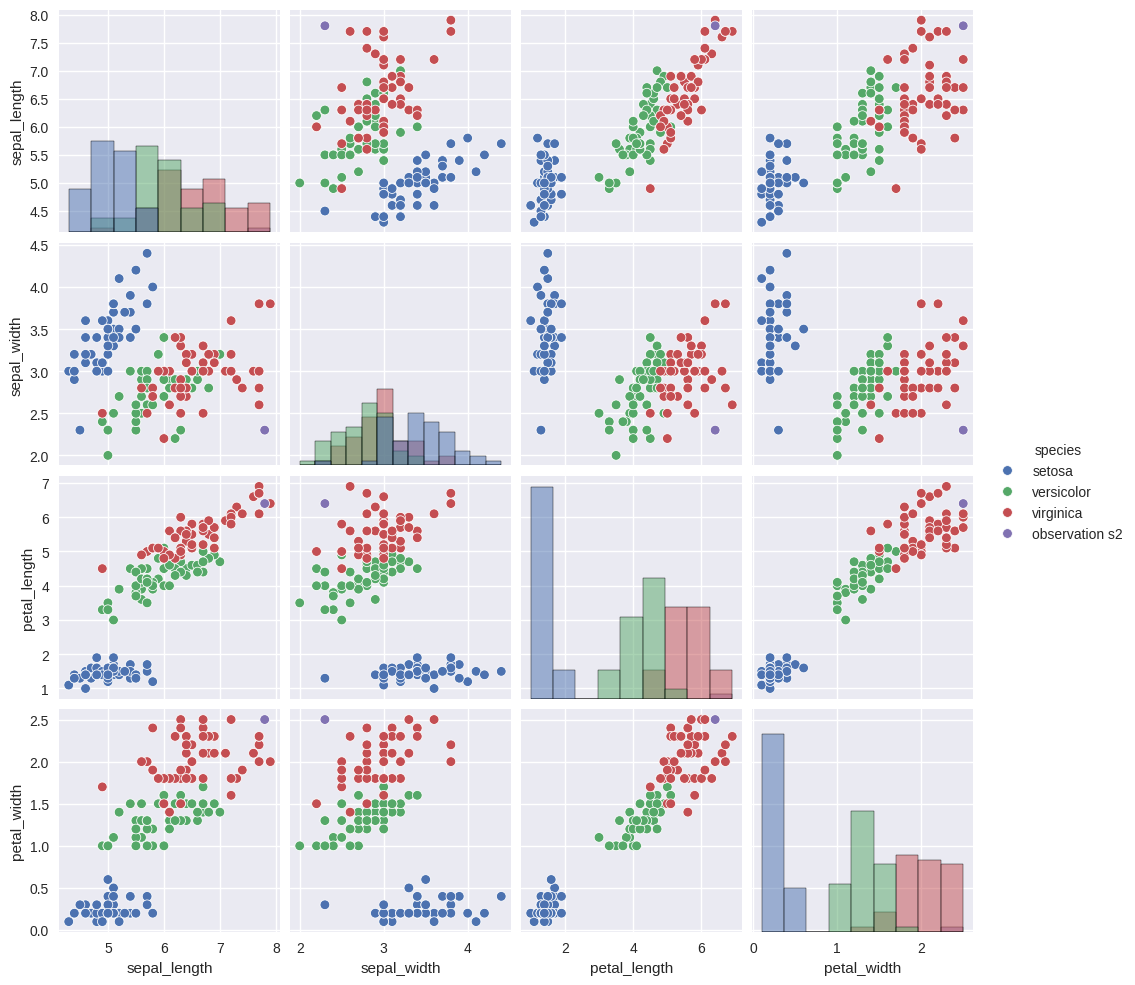

In [23]:
# init the plot
plt.figure(figsize=(10, 10))

# load the dataset also available in seaborn
iris_plot = sns.load_dataset("iris")

x_s2_feature_vector = [7.8, 2.3, 6.4, 2.50, "observation s2"]
# add observations to the iris dataset
new_observation_df = pd.DataFrame([x_s2_feature_vector], columns=iris_plot.columns)
iris_plot = pd.concat([iris_plot, new_observation_df], ignore_index=True)
# plot a pairplot of the distinct feature distributions
sns.pairplot(iris_plot, diag_kind='hist', hue='species');

Ok, the feature distributions of the feature values observable for the unknown iris flower $x^{s1}$ exhibit a high likelihood of beeing of class **virginica**.

## c. Linear SVM Classifers - The Non-Linear Seperable Case

Ok, great we have seen how to apply Support Vector classification to separable data. So how can we extend these ideas to handle non-separable data? To achieve this we would like to relax the initial constraints $ x_{i} \cdot w + b \geq + 1, y_{i} = +1 $ and $ x_{i} \cdot w + b \leq - 1, y_{i} = -1 $ when necessary. That is, we would like to introduce a further cost for doing so. This can be done by the introducing of so-called positive **"slack variables"** denoted $\xi_{i}, i=1, ..., l$ in the Lagrange optimization $L_{P}$.

Therefore, the initial constraints become:

$$ x_{i} \cdot w + b \geq + 1 - \xi_{i}, y_{i} = +1 $$

$$ x_{i} \cdot w + b \leq - 1 + \xi_{i}, y_{i} = -1 $$

$$ \xi_{i} \geq 0,  \forall i$$

Thus, for an error to occur, the corresponding $\xi_{i}$ must exceed unity. As a result, $\sum_{i=1}^{l} \xi_{i}$ defines an upper bound on the number of training errors.

### i. a "Primal"  Optimization Objective Formulation

A natural way to assign such an extra cost for errors is to add it to the primal Lagrangian objective function $L_{P}$ to be optimized. The Lagrangian therefore becomes:

$$L_{P} = \frac{1}{2}||w||^{2} + C \sum_{i=1}^{l} \xi_{i} - \sum_{i=1}^{l} \alpha_{i}\{y_{i}(x_{i} \cdot w + b) -1 + \xi_{i}\} + \sum_{i=1}^{l}\alpha_{i} - \sum_{i=1}^{l} \mu_{i} \xi_{i} $$

where $C$ is a parameter determines the penalty magnitude of errors. Furthermore, $\mu_{i}$ are another set of Lagrange multipliers introduced to enforce positivity of the slack variables $\xi_{i}$. We must now minimize $L_{P}$ with respect to $w$, $b$. Thereby,

> 1. the minimization of the first term $\frac{1}{2}||w||^{2}$ maximizes the margin of the separating hyperplane,
> 2. the minimization of the second term $C \sum_{i=1}^{l} \xi_{i}$ minimizes the penalty of misclassfied training samples,
> 3. the maximization of the third term $\sum_{i=1}^{l} \alpha_{i}y_{i}(x_{i} \cdot w + b)$ maximizes the number of correctly classfied training samples,
> 4. the minimization of the fourth term $\sum_{i=1}^{l}\alpha_{i}$ minimizes the number of support vectors,
> 5. the maximization of the fifth term $\sum_{i=1}^{l} \mu_{i} \xi_{i}$ enforces the positivity of the slack variables.

In general, the penalty term $C$ is a parameter to be chosen by the user. A larger $C$ corresponds to assigning a higher penalty to errors.

### ii. a "Dual" Optimization Objective Formulation

We can again derive a dual formulation of the optimization objective using the conditions that $w = \sum_{i=1}^{l} \alpha_{i}y_{i}x_{i}$ and $\sum_{i=1}^{l}\alpha_{i}y_{i} = 0$, which becomes:

$$L_{D} = \sum_{i=1}^{l}\alpha_{i} + \frac{1}{2} \sum_{i,j=1}^{l} \alpha_{i}\alpha_{j}y_{i}y_{j}<x_{i}, x_{j}>$$

subject to $0 \leq \alpha_{i} \leq C$. The only difference in comparison to the optimal hyperplane case is that the $\alpha_{i}$ now have an upper bound of C. Again, the optimal seperating hyperplane $H^{*}$ still remains a linear function of the training data.

### iii. training


Let's inspect different parametrizations of $C$ and their corresponding impact on the determined support vectors and learned optimal separating hyperplane $H^{*}$. We can obtain the learned support vectors from the model using the `support_vectors_` method available `Scikit-Learn`. Let's again fit a linear SVM to the training data observations $x_{i}$ using a penalty of $C=1$:

In [24]:
# init the Support Vector Machine classifier
svm = SVC(kernel='linear', C=1, random_state=random_seed)

We will train the SVM model on the sepal length $x_1$ and petal length $x_3$ features of the iris flower dataset to seperate flowers of the classes $c_{1}=$ versicolor and $c_{2}=$ virginica:

In [25]:
x_train_test = x_train[y_train != 0, :][:, [0,2]]
y_train_test = y_train[y_train != 0]

Let's fit the linear SVM model:

In [26]:
svm.fit(x_train_test, y_train_test)

SVC(C=1, kernel='linear', random_state=42)

Let's briefly glance over the determined support vectors for which $\alpha_{i} > 0$ and that constitute the learned max-margin separating hyperplane $H^{*}$:

In [27]:
svm.support_vectors_

array([[5.6, 4.5],
       [5.4, 4.5],
       [6.7, 5. ],
       [5.9, 4.8],
       [6. , 5.1],
       [6.3, 4.9],
       [6.1, 4.7],
       [6.5, 4.6],
       [6.1, 4.6],
       [6.6, 4.6],
       [5.5, 4.4],
       [6.9, 4.9],
       [6.3, 5.1],
       [6.3, 4.9],
       [5.7, 5. ],
       [6. , 4.8],
       [5.8, 5.1],
       [6. , 5. ],
       [6.2, 4.8],
       [6.9, 5.4],
       [6.5, 5.2],
       [5.6, 4.9],
       [5.9, 5.1],
       [4.9, 4.5]])

Finally, let's visually inspect the maximum margin separating hyperplane $H^{*}$ that was learned by our SVM. Remember, the learned hyperplane was optimized to seperate the features sepal length $x_1$ and petal length $x_3$ of the iris flower classes $c_{1}=$ versicolor and $c_{2}=$ virginica:

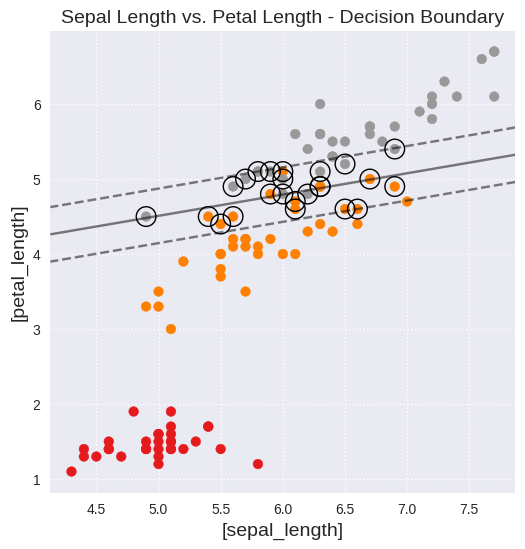

In [28]:
# init the plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot sepal length vs. petal length and corresponding classes
ax.scatter(x_train[:,0], x_train[:,2], c=y_train, cmap=plt.cm.Set1)

# highlight the determined support vectors in green
ax.scatter(svm.support_vectors_[:,0], svm.support_vectors_[:,1], s=200, linewidth=1, facecolor='none', edgecolors='k', label='support vectors')

# determine axis ranges
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create meshgrid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# determine and plot decision boundary
Z = svm.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# add axis legends
ax.set_xlabel("[sepal_length]", fontsize=14)
ax.set_ylabel("[petal_length]", fontsize=14)

# add plot title
plt.title('Sepal Length vs. Petal Length - Decision Boundary', fontsize=14);

Ok, we can observe how the learned 24 support vectors nicely constitute the optimal maximum margin separating hyperplane $H^{*}$. Let's now investigate how different values of $C \in \{0.1, 10, 100, 1000\}$ will penalize and therefore affect the number of support vectors. Remember, a larger value of $C$ corresponds to assigning a higher penalty to errors:

In [29]:
# init distinct C values
C_values = [0.1, 1, 10, 100]

# init SVM models of distinct C values
svm_models = (SVC(kernel='linear', C=C, random_state=random_seed) for C in C_values)

Let's fit the linear SVM models using distinct values of the penalty term $C$:

In [30]:
# fit the distinct SVM models to the data
svm_models = (model.fit(x_train_test, y_train_test) for model in svm_models)

Let's now again visually inspect the maximum margin separating hyperplane $H^{*}$ that was learned by our SVM and applying different values of $C$:

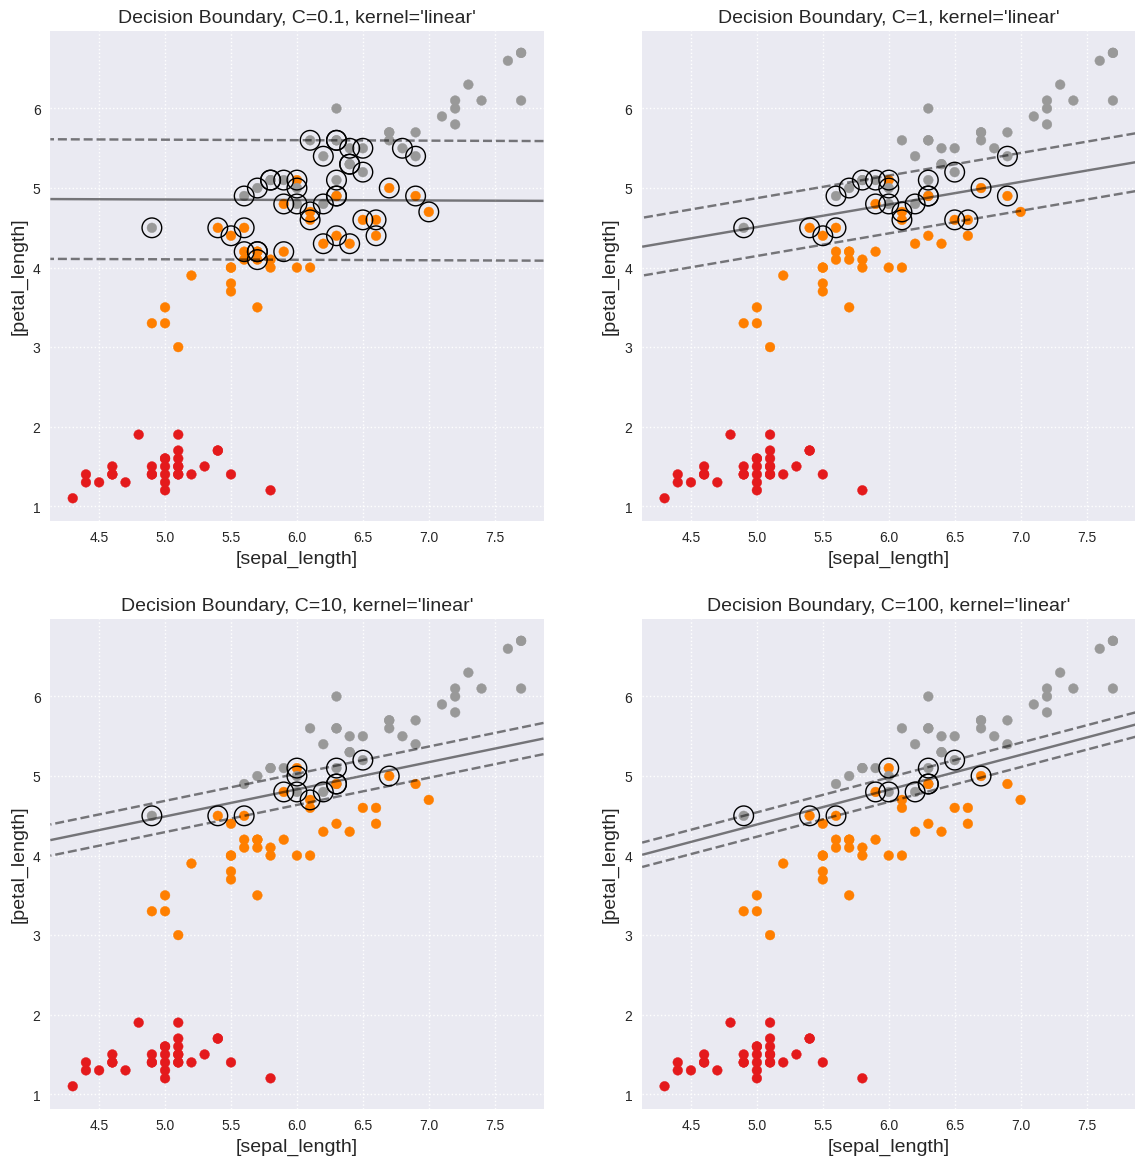

In [31]:
# init the plot
fig, sub = plt.subplots(2, 2, figsize=(14, 14))

# iterate over distinct models
for model, ax in zip(svm_models, sub.flatten()):

    # add grid
    ax.grid(linestyle='dotted')

    # plot sepal length vs. petal length and corresponding classes
    ax.scatter(x_train[:,0], x_train[:,2], c=y_train, cmap=plt.cm.Set1)

    # highlight the determined support vectors in green
    ax.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1], s=200, linewidth=1, facecolor='none', edgecolors='k', label='support vectors')

    # determine and plot decision boundary
    Z = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # add axis legends
    ax.set_xlabel("[sepal_length]", fontsize=14)
    ax.set_ylabel("[petal_length]", fontsize=14)

    # add plot title
    ax.set_title('Decision Boundary, C={}, kernel=\'{}\''.format(str(model.C), str(model.kernel)), fontsize=14);

We can indeed observe that with increasing $C$ the number of misclassifications as well as the number of support vectors that constitute $H^{*}$ decreases.

## c. Non-Linear SVM Classifiers

How can the above linear SVMs be generalised to the case where the optimal separating hyperplane $H^{*}$ can not be formulated as a linear function of the data? This holds for instances when the training data is not linearly separable. Boser, Guyon and Vapnik showed the so-called **"kernel trick"** could be used to accomplish this in a surprisingly straightforward way. First notice again, from the training objectives dual formulation, that the only way in which the data appears in the objective is in the form of dot products $<x_{i}, x_{j}>$. Now suppose we first mapped the data to some other (possibly infinite-dimensional) Euclidean space $\mathcal{H}$, using the mapping which we will call $\phi$:

$$\phi: \mathcal{R}^{d} \mapsto \mathcal{H}$$

Then, of course, the training algorithm would only depend on the data through dot products in $\mathcal{H}$, i.e. on functions of the form $\phi(x_{i}) \cdot \phi(x_{j})$. Now if there were a **"kernel function"** $K$ such that $K(x_{i}, x_{j}) = \phi(x_{i}) \cdot \phi(x_{j})$, we would only need to use $K$ in the training algorithm, and would never need to explicitly even know what $\phi$ is. One such kernel function is:

$$K(x_{i}, x_{j}) = e^{-||x_{i}-x_{j}||^{2} / 2 \sigma^{2}} $$

In this particular example, $\mathcal{H}$ is infinite-dimensional, so it would not be very easy to work with $\phi$ explicitly. However, if one replaces $x_{i} \cdot x_{j}$ by $K(x_{i}, x_{j})$ everywhere in the training procedure, the algorithm will happily produce a SVM which lives in an infinite-dimensional space. All considerations of the previous sections still hold, since we are still doing a linear separation but in a different space. Since we can again derive a dual formulation of the optimisation objective using the conditions that $w = \sum_{i=1}^{l} \alpha_{i}y_{i}x_{i}$ and $\sum_{i=1}^{l}\alpha_{i}y_{i} = 0$, which becomes:

$$L_{D} = \sum_{i=1}^{l}\alpha_{i} + \frac{1}{2} \sum_{i,j=1}^{l} \alpha_{i}\alpha_{j}y_{i}y_{j}K(x_{i}, x_{j})$$

subject to $0 \leq \alpha_{i} \leq C$. The only difference in comparison to the linear hyperplane case is that the dot product $<x_{i}, x_{j}>$ is now replaced by a kernel function $K(x_{i}, x_{j})$.

### i. training

Let's now train a set of non-linear SVMs and evaluate different kernel functions $K(x_{i}, x_{j})$. We will again train the distinct SVM models on the sepal length $x_1$ and petal length $x_3$ features of the iris flower dataset to separate the distinct flower classes $c_{0}=$ setosa, $c_{1}=$ versicolor and $c_{2}=$ virginica:

In [32]:
x_train_kernel = x_train[:, [0, 2]]
y_train_kernel = y_train

Next, we will instantiate several SVM models each equipped with a different kernel function. Thereby, we will use three of the kernel functions already available in the `Scikit-Learn` library:

> 1. linear kernel function: **$<x_{i}, x_{j}>$**,
> 2. radial-basis kernel-function: $exp({- \gamma ||x_{i}, x_{j}||^{2}})$, where $\gamma$ is specified by the keyword `gamma` and must be greater than 0,
> 3. polynomial kernel-function: $(\gamma <x_{i}, x_{j}> + r)^{d}$, where $d$ is specified by the keyword `degree` and $r$ by `coef0`.

Let's instantiate the distinct SVM models accordingly:

In [34]:
# init the SVM models using distinct kernel functions
svm_models = (SVC(kernel='linear', C=1)
              , SVC(kernel='rbf', gamma=0.1, C=1)
              , SVC(kernel='rbf', gamma=0.2, C=1)
              , SVC(kernel='rbf', gamma=0.5, C=1)
              , SVC(kernel='rbf', gamma=0.7, C=1)
              , SVC(kernel='poly', degree=1, coef0=1.0, C=1)
              , SVC(kernel='poly', degree=2, coef0=1.0, C=1)
              , SVC(kernel='poly', degree=5, coef0=1.0, C=1)
              , SVC(kernel='poly', degree=7, coef0=1.0, C=1))

Let's subsequently train the distinct SVM models:

In [35]:
# fit the distinct SVM models to the data
svm_models = (model.fit(x_train_kernel, y_train_kernel) for model in svm_models)

Let's visually inspect the optimal separating hyperplane $H^{*}$ learned by the distinct kernel functions $K(x_{i}, x_{j})$ to separate the sepal length $x_1$ and petal length $x_3$ features :

SVC(C=1, kernel='linear')
SVC(C=1, gamma=0.1)
SVC(C=1, gamma=0.2)
SVC(C=1, gamma=0.5)
SVC(C=1, gamma=0.7)
SVC(C=1, coef0=1.0, degree=1, kernel='poly')
SVC(C=1, coef0=1.0, degree=2, kernel='poly')
SVC(C=1, coef0=1.0, degree=5, kernel='poly')
SVC(C=1, coef0=1.0, degree=7, kernel='poly')


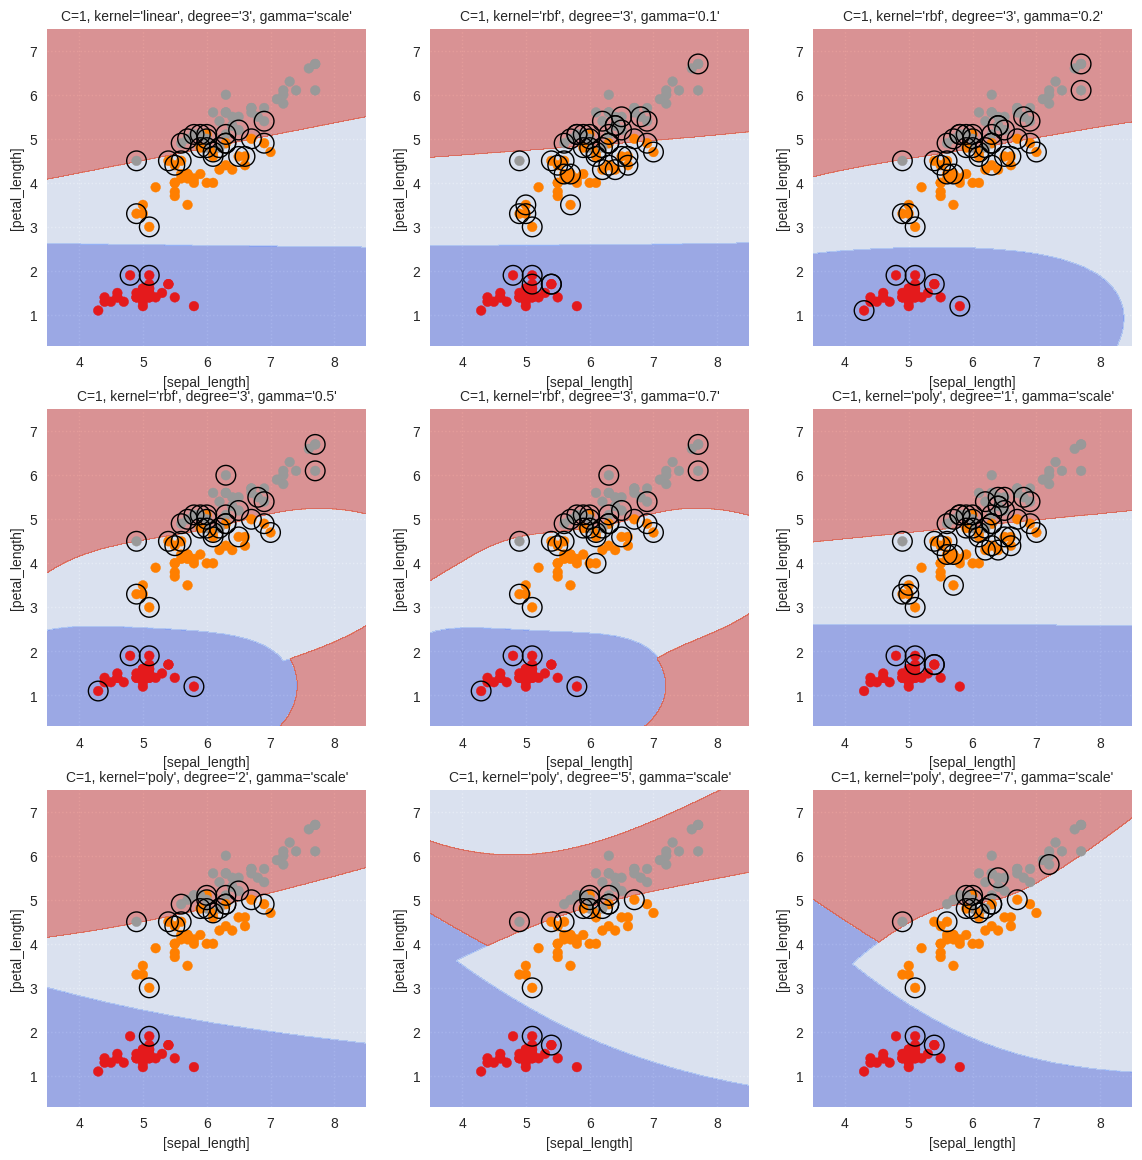

In [36]:
# init the plot
fig, sub = plt.subplots(3, 3, figsize=(14, 14))

# determine mesh-grid limitations
xlim = [np.min(x_train[:, 0]) - 0.8, np.max(x_train[:, 0]) + 0.8]
ylim = [np.min(x_train[:, 2]) - 0.8, np.max(x_train[:, 2]) + 0.8]

# create meshgrid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 1000)
yy = np.linspace(ylim[0], ylim[1], 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# iterate over distinct models
for model, ax in zip(svm_models, sub.flatten()):

    print(model)

    # add grid
    ax.grid(linestyle='dotted')

    Z = model.predict(xy).reshape(XX.shape)
    ax.contourf(XX, YY, Z, alpha=0.5, cmap=plt.cm.coolwarm)

    # plot sepal length vs. petal length and corresponding classes
    ax.scatter(x_train[:,0], x_train[:,2], c=y_train, cmap=plt.cm.Set1)

    # highlight the determined support vectors in green
    ax.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1], s=200, linewidth=1, facecolor='none', edgecolors='k', label='support vectors')

    # set axis ranges
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # add axis legends
    ax.set_xlabel('[sepal_length]', fontsize=10)
    ax.set_ylabel('[petal_length]', fontsize=10)

    # add plot title
    ax.set_title('C={}, kernel=\'{}\', degree=\'{}\', gamma=\'{}\''.format(str(model.C), str(model.kernel), str(model.degree), str(model.gamma)), fontsize=10);